# BM25 (ranking algorithm) to find reviews mentioning fake ads

In [ ]:
!pip install rank_bm25

In [3]:
from rank_bm25 import BM25Okapi
import pandas as pd
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Define path inside Google Drive
save_path = "/content/drive/MyDrive/Youtube_Game_Ads/Reviews/"
os.makedirs(save_path, exist_ok=True)
hero_wars = pd.read_csv(save_path + "Hero wars.csv")
puzzles_and_survival = pd.read_csv(save_path + "Puzzles and survival.csv")
project_makeover = pd.read_csv(save_path + "Project makeover.csv")
hustle_castle = pd.read_csv(save_path + "Hustle Castle.csv")
last_fortress = pd.read_csv(save_path + "Last fortress.csv")

In [29]:
# Load dataset
df = puzzles_and_survival
df['content'] = df['content'].astype(str).str.lower()

# Convert 'at' column (timestamp) to datetime format
df['at'] = pd.to_datetime(df['at'])

# Tokenize reviews
corpus = df["content"].tolist()
tokenized_corpus = [doc.split(" ") for doc in corpus]

# Initialize BM25 model
bm25 = BM25Okapi(tokenized_corpus)

# Define search queries for each misleading ad category
misleading_ad_categories = {
    "Bait-and-Switch": [
        "bait and switch", "not like the ad", "different from ad", "ad lies", "nothing like the ad",
        "fake game ad", "nothing like advertised", "not what i expected",
        "not the game from the ad", "ad was misleading"
    ],
    "Fake Incompetence": [
        "fake mistakes", "they fail on purpose",
        "character keep failing", "so dumb in the ad"
    ],
    "Emotional Manipulation": [
        "sad story ad", "made me feel guilty",
        "manipulative ad", "make me feel angry", "make me feel bad"
    ],
    "Sexualized Clickbait": [
        "inappropriate ad", "sexualized ad", "provocative ad",
        "sexism", "offensive", "misogynistic ads", "sexy ad"
    ],
    "False Storylines": [
        "story not in the game", "fake storyline", "not the same story",
        "ad tells a different story", "story is completely different"
    ],
    "Borrowed IP": [
        "copied characters", "not the real brand",
        "used characters not in the game", "misleading character use",
        "famous characters"
    ],
    "Exaggerated Difficulty": [
        "game is way too easy", "boring game", "ad says it's hard but it's not",
        "not a challenge at all", "ad lies about difficulty",
        "not as hard as the ad", "easy game not like ad"
    ]
}

# Store the best match for each review
best_category_results = {}

# Iterate through each category and compute scores for all reviews
for category, queries in misleading_ad_categories.items():
    for query in queries:
        tokenized_query = query.lower().split(" ")
        scores = bm25.get_scores(tokenized_query)

        for idx, score in enumerate(scores):
            review = corpus[idx]
            review_id = df.iloc[idx]['reviewId']
            timestamp = df.iloc[idx]['at']

            # If this review gets a higher score for a different category, update it
            if review not in best_category_results or best_category_results[review]["score"] < score:
                best_category_results[review] = {
                    "reviewId": review_id,
                    "timestamp": timestamp,
                    "category": category,
                    "query": query,
                    "score": score
                }

# Convert best results into a DataFrame
final_results = [
    (details["reviewId"], details["timestamp"], review, details["category"], details["query"], details["score"])
    for review, details in best_category_results.items()
]

final_df = pd.DataFrame(final_results, columns=["ReviewId", "Timestamp", "Review", "Category", "Query", "BM25 Score"])

# Save final results where each review appears only once under the highest BM25 score category
final_df.to_csv("/content/drive/MyDrive/Youtube_Game_Ads/Reviews/Categorized_Reviews_with_Highest_Score.csv", index=False)

# Optionally, filter by a threshold
threshold = 5.0
filtered_df = final_df[final_df["BM25 Score"] >= threshold]

# Display filtered results
filtered_df


,ReviewId,Timestamp,Review,Category,Query,BM25 Score
3,6a24adbe-baf1-4916-985d-7b36f1f751dc,2025-02-25 11:35:00,is it really that hard to make a game that mat...,Exaggerated Difficulty,not as hard as the ad,5.748144
9,2df33049-dd70-4f04-803a-d6e058478c01,2025-02-24 20:02:00,misleading advertisement,Bait-and-Switch,ad was misleading,8.714658
10,2056e55d-cd8e-4624-8ca1-c484716ce06f,2025-02-24 19:11:00,horrible nothing like the ad don't download,Bait-and-Switch,nothing like the ad,13.852208
25,536e84ec-f793-47bf-bbb3-bf2b7e4655b8,2025-02-23 04:30:00,why cant any company give us the game they adv...,Bait-and-Switch,bait and switch,9.850046
33,835e5b33-804a-4f75-9ffd-a2f2093ad39f,2025-02-22 14:14:00,"i wanted to shoot zombies, but it's 3 in row t...",Exaggerated Difficulty,ad says it's hard but it's not,6.475088
...,...,...,...,...,...,...
7562,eb7f17ea-f815-4899-99ac-339c3bc2b9a1,2023-04-16 14:05:00,it's a fun game but it can be a bit of a grind,Exaggerated Difficulty,ad says it's hard but it's not,6.475088
7570,e3cbd6cb-2a77-4c57-a645-cb1a31bc8182,2023-04-15 23:28:00,will take your money! everything was wiped cle...,Exaggerated Difficulty,not as hard as the ad,6.898275
7572,1de82234-be98-4d07-9881-5bb91266229d,2023-04-15 22:00:00,"simple and grinding, something to kill a bit o...",Exaggerated Difficulty,not as hard as the ad,5.515328
7579,db319594-aa14-4314-96b6-09f076ed84d7,2023-04-15 10:29:00,nice game with capcom re characters,Borrowed IP,used characters not in the game,7.534594


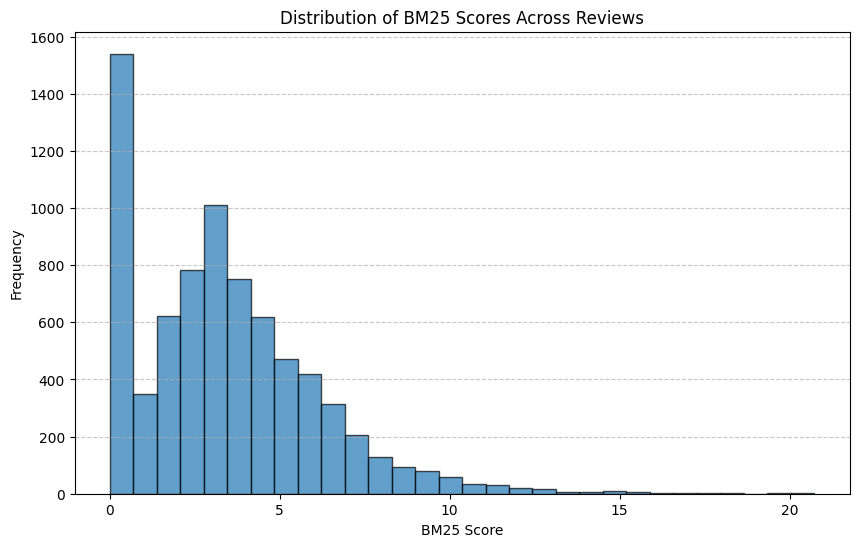

In [19]:
import matplotlib.pyplot as plt

# Plot histogram of BM25 scores
plt.figure(figsize=(10, 6))
plt.hist(final_df["BM25 Score"], bins=30, edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel("BM25 Score")
plt.ylabel("Frequency")
plt.title("Distribution of BM25 Scores Across Reviews")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

In [22]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [24]:
import pandas as pd
from bertopic import BERTopic

In [23]:
def apply_topic_modeling(df, text_column="content", nr_topics=40, topic_column="topic"):
    """
    Applies BERTopic modeling on a specified text column in a DataFrame.
    Allows specifying a different column name for topics to prevent overwriting.
    """

    df = df.dropna(subset=[text_column]).copy()
    docs = df[text_column].astype(str).tolist()

    # Apply BERTopic
    topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True, nr_topics=nr_topics)
    topics, probs = topic_model.fit_transform(docs)

    # Store results in a custom column
    df[topic_column] = topics
    df[f"{topic_column}_info"] = df[topic_column].apply(
        lambda t: topic_model.topic_labels_[t] if t in topic_model.topic_labels_ else "Unknown"
    )

    # Get topic frequency
    topic_freq = topic_model.get_topic_info()

    return df, topic_freq, topic_model

In [26]:
filtered_df_topic, topic_freq, topic_model = apply_topic_modeling(filtered_df, text_column="Review", topic_column="topic", nr_topics=10)
topic_freq

2025-03-02 22:31:47,639 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/56 [00:00<?, ?it/s]

2025-03-02 22:32:11,909 - BERTopic - Embedding - Completed ✓
2025-03-02 22:32:11,910 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-02 22:32:20,027 - BERTopic - Dimensionality - Completed ✓
2025-03-02 22:32:20,028 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-02 22:32:20,344 - BERTopic - Cluster - Completed ✓
2025-03-02 22:32:20,345 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-02 22:32:20,416 - BERTopic - Representation - Completed ✓
2025-03-02 22:32:20,417 - BERTopic - Topic reduction - Reducing number of topics
2025-03-02 22:32:20,503 - BERTopic - Topic reduction - Reduced number of topics from 39 to 10


,Topic,Count,Name,Representation,Representative_Docs
0,-1,502,-1_the_game_to_not,"[the, game, to, not, its, it, as, and, is, but]",[yet another game where the ads have absolutel...
1,0,542,0_to_its_game_fun,"[to, its, game, fun, and, the, easy, you, but,...",[this is really my first time playing this typ...
2,1,460,1_the_game_like_ads,"[the, game, like, ads, not, ad, is, nothing, a...",[this game is nothing like they show in the ad...
3,2,118,2_bad_its_good_not,"[bad, its, good, not, ok, far, so, but, pretty...","[so far not bad, not to bad but good, it's goo..."
4,3,69,3_it_to_my_the,"[it, to, my, the, and, not, game, app, loading...",[it will not let me connect to the game withou...
5,4,25,4_adds_add_the_like,"[adds, add, the, like, show, not, it, game, no...","[not the game in the add, nothing like the add..."
6,5,20,5_women_the_is_female,"[women, the, is, female, men, are, to, charact...",[the way the girl doctor is dressed is misogyn...
7,6,17,6_too_much_glitches_many,"[too, much, glitches, many, way, takes, story,...","[too much work, way too much storyline, way to..."
8,7,16,7_bait_switch_click_and,"[bait, switch, click, and, transformers, waste...","[bait game, another bait and switch., bait and..."
9,8,11,8_what_expected_expecting_not,"[what, expected, expecting, not, thought, was,...","[not what i was expecting, not what i expected..."
